In [75]:
import pickle
import subprocess
import tensorflow as tf
import gym
from sklearn.model_selection import train_test_split, ParameterGrid
import numpy as np
from tqdm import tqdm_notebook, tqdm, trange
from collections import defaultdict
import load_policy

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [19]:
experts = ["Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Humanoid-v2", "Reacher-v2", "Walker2d-v2"]

### Generating expert data :

In [20]:
def runExpert(expert, rollouts) :
    process = subprocess.Popen("python run_expert.py experts/{0}.pkl {1} --num_rollouts {2}".format(expert, expert, rollouts), shell = True)
    process.wait()

In [21]:
rollouts = 20
for expert in experts :
    runExpert(expert, rollouts)

### Getting observations, actions from expert data :

In [22]:
def getExpertData(expert) :
    with open("expert_data/{}.pkl".format(expert), "rb") as f :
        data = pickle.load(f)
    return(data)

### Observations and Actions :
Observation is an array of shape (m, dim_obs) where m are the number of observations and dim_obs is the dimension of the observation array
Action is an array of shape (m, 1, dim_act)

For the Ant-v2 case, dim_obs = 111 and dim_act = 8

In [23]:
data = getExpertData("Ant-v2")

In [24]:
data["observations"].shape

(20000, 111)

In [25]:
data["actions"].shape

(20000, 1, 8)

### Behavior Cloning :

In [28]:
def prepareData(expert) :
    expert_data = getExpertData(expert)
    observations, actions, returns = expert_data.values()
    #Reshaping action to 2d
    actions = actions.reshape((actions.shape[0], actions.shape[-1]))
    #Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(observations, actions, test_size = 0.1, random_state = 1)
    
    return(X_train, X_test, y_train, y_test)

In [32]:
def behaviorCloning(observations, actions, lr = 0.001, epochs = 10, batch_size = 100) :
    #Getting shapes which are used in input and output layers of the network
    obs_shape = observations.shape
    act_shape = actions.shape
    
    model = Sequential()
    model.add(InputLayer(input_shape = obs_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(units = 32, activation = "relu"))
    model.add(Dense(units = 32, activation = "relu"))
    model.add(Dense(units = act_shape[-1]))
    
    optimizer = Adam(lr)
    
    model.compile(optimizer = optimizer, loss = "mse", metrics = ["mse"])
    
    model.fit(x = observations, y = actions, epochs = epochs, batch_size = batch_size, verbose = 0)

    return(model)

### Hyperparameter tuning :

In [49]:
"""
params = {"lr" : [0.001, 0.01, 0.1], "epochs" : [10, 20, 50]}
batch_size = 100
validation_results = defaultdict(list)
for expert in experts :
    print("Expert : {}".format(expert))
    X_train, X_test, y_train, y_test = prepareData(expert)
    for parameters in tqdm_notebook(ParameterGrid(params), desc = "Parameter Grid") :
        lr, epochs = parameters["lr"], parameters["epochs"]
        model = behaviorCloning(X_train, y_train, lr, epochs, batch_size)
        res = model.evaluate(X_test, y_test, verbose = 0)
        validation_results[expert].append((lr, epochs, batch_size, res[0]))
"""

'\nparams = {"lr" : [0.001, 0.01, 0.1], "epochs" : [10, 20, 50]}\nbatch_size = 100\nvalidation_results = defaultdict(list)\nfor expert in experts :\n    print("Expert : {}".format(expert))\n    X_train, X_test, y_train, y_test = prepareData(expert)\n    for parameters in tqdm_notebook(ParameterGrid(params), desc = "Parameter Grid") :\n        lr, epochs = parameters["lr"], parameters["epochs"]\n        model = behaviorCloning(X_train, y_train, lr, epochs, batch_size)\n        res = model.evaluate(X_test, y_test, verbose = 0)\n        validation_results[expert].append((lr, epochs, batch_size, res[0]))\n'

In [50]:
def getReturns(expert, model, rollouts) :
    model_returns = []
    env = gym.make(expert)
    max_steps = env.spec.timestep_limit
    for i in range(rollouts):
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            obs = obs.reshape((1, obs.shape[0]))
            action = model.predict(obs)
            action = action.reshape((action.shape[0], 1, action.shape[1]))
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if steps >= max_steps:
                    break
        model_returns.append(totalr)
    return(model_returns)

In [51]:
import pandas as pd

In [63]:
results = []
for expert in experts :
    print("\rExpert : {}".format(expert), end = "")
    expert_data = getExpertData(expert)
    observations, actions, expert_returns = expert_data["observations"], expert_data["actions"], expert_data["returns"]
    actions = np.squeeze(actions)
    model = behaviorCloning(observations, actions, lr = 0.001, epochs = 20, batch_size = 100)
    model_returns = getReturns(expert, model, 20)
    results.append([expert, np.mean(expert_returns), np.mean(model_returns), np.std(expert_returns), np.std(model_returns)])

Expert : Walker2d-v2

In [64]:
df = pd.DataFrame(results, columns = ["Expert", "Mean Expert Returns", "Mean Model Returns", "Std Expert Returns", "Std Model Returns"])
df

,Expert,Mean Expert Returns,Mean Model Returns,Std Expert Returns,Std Model Returns
0,Ant-v2,4643.365419,4715.059918,721.400246,100.725479
1,HalfCheetah-v2,4148.390453,3888.772914,93.052040,81.794357
2,Hopper-v2,3777.427432,634.488760,3.983109,6.815471
3,Humanoid-v2,10414.474915,1280.554422,49.053790,946.155600
4,Reacher-v2,-3.484670,-12.215830,1.929408,2.441112
5,Walker2d-v2,5515.393810,771.369222,57.088761,458.843686


In [65]:
df.to_csv("expert_data/behaviorcloning_results.csv")

### DAgger Algorithm :

In [184]:
def DAgger(expert, observations, actions, parameters, iterations) :
    obs_dataset = []
    act_dataset = []
    rewards = []
    lr, epochs, batch_size = parameters["lr"], parameters["epochs"], parameters["batch_size"]
    train_observations, train_actions = observations, actions
    for i in tqdm_notebook(range(iterations), desc = "DAgger Iteration") :
        #Train model on training set D
        model = behaviorCloning(train_observations, train_actions, lr, epochs, batch_size)
        env = gym.make(expert)
        max_steps = env.spec.timestep_limit
        
        #Using trained model to get mean rewards
        rollouts = 20
        returns = []
        for j in range(rollouts):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                obs = obs.reshape((1, obs.shape[0]))
                model_action = model.predict(obs)
                model_action = model_action.reshape((model_action.shape[0], 1, model_action.shape[1]))
                obs, r, done, _ = env.step(model_action)
                totalr += r
                steps += 1
                if steps >= max_steps:
                    break
            returns.append(totalr)
        rewards.append(returns)
        
        
        #Start with initial observation and run model to get [o1, o2, o3]
        new_observations = []
        obs = env.reset()
        done = False
        steps = 0
        while not done:
            new_observations.append(obs)
            obs = obs.reshape((1, obs.shape[0]))
            model_action = model.predict(obs)
            model_action = model_action.reshape((model_action.shape[0], 1, model_action.shape[1]))
            obs, r, done, _ = env.step(model_action)
            steps += 1
            if steps >= max_steps:
                break
                    
        #Keeping track of rewards
        #rewards.append(totalr)
        
        #Use these observations as input to expert and get expert actions
        with tf.Session() :
            env = gym.make(expert)
            policy_fn = load_policy.load_policy("experts/{}.pkl".format(expert))
            new_actions = []

            for nobs in new_observations :
                expert_action = policy_fn(nobs[None,:])
                new_actions.append(expert_action)
            
        #Get labeled set D_exp = [(o1, a1), (o2, a2), ...]
        #Aggregate this to training set (D = D + D_exp) and retrain model
        obs_dataset.append(train_observations)
        act_dataset.append(train_actions)
        train_observations = np.concatenate((train_observations, np.array(new_observations)))
        train_actions = np.concatenate((train_actions, np.squeeze(np.array(new_actions))))
        
    return(obs_dataset, act_dataset, rewards)

#### Running DAgger for Hopper-v2

In [185]:
expert = "Hopper-v2"
expert_data = getExpertData(expert)
observations, actions, expert_returns = expert_data["observations"], expert_data["actions"], expert_data["returns"]
actions = np.squeeze(actions)
obs_dataset, act_dataset, rewards = DAgger(expert, observations, actions, {"lr" : 0.001, "epochs" : 20, "batch_size" : 100}, 20)

obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)
obs (1, 11) (1, 11)


In [187]:
from scipy.stats import sem

In [223]:
plt.rc('font', family = "serif")
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

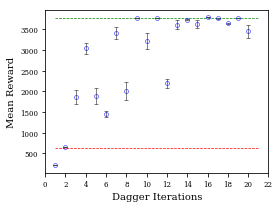

In [253]:
mean_rewards = [np.mean(rollout_rewards) for rollout_rewards in rewards]
stderr_rewards = [sem(rollout_rewards) for rollout_rewards in rewards]
expert_performance = df[df["Expert"] == "Hopper-v2"]["Mean Expert Returns"].values[0]
bc_performance = df[df["Expert"] == "Hopper-v2"]["Mean Model Returns"].values[0]
x = np.arange(1, 21, 1)


fig, ax = plt.subplots(figsize = (4, 3))
ax.errorbar(x, mean_rewards, fmt = "o", yerr = stderr_rewards, ecolor = "black", mfc = "None", markersize = 4, mec = "blue", capsize = 2, alpha = 0.7, mew = 0.7, elinewidth = 0.7)
ax.plot([1, 21], [expert_performance, expert_performance], linestyle = "--", color = "green", linewidth = 0.7)
ax.plot([1, 21], [bc_performance, bc_performance], linestyle = "--", color = "red", linewidth = 0.7)
ax.set_xlabel("Dagger Iterations")
ax.set_ylabel("Mean Reward")
ax.set_xticks(np.arange(0, 23, 2))
fig.savefig("Hopper-v2-dagger.png", bbox_inches = "tight", dpi = 300)
plt.show()